In [1]:
%gui qt
%matplotlib notebook

import pandas as pd
import numpy as np
import scipy
from scipy import stats,signal
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import KF2D
import pickle
import os
import cpd
import glob
from scipy.signal import hilbert

from numpy import linalg as LA

from filters import butter_lowpass_lfilter, butter_highpass_lfilter
from pykalman import KalmanFilter
import peakdet
import pdb
from __future__ import division
from itertools import compress

fs = 25

## Open saved data (pickle)

In [142]:
os.chdir('/Users/sazamore/Documents/Visuomotor/1-Raw_data/')#Visuomotor/Raw_data')
# os.chdir('/Users/sazamore/Documents/Visuomotor/2-Processed_data/')
#If you want to open a file from another folder, create a new cell, type "cd" then "cd/FOLDER/FOLDER" to change the 
#working directory to the folder that contains your file.
files = glob.glob('94_03rpm_170329-raw.p')

filename = files[0]
Date = filename[-12:-6]
ID = int(filename[:2])
try:
    Date = int(Date)
    print(filename)
except ValueError:
    print(Date)
    print('Filename is {}'.format(filename))
    print('Date not readible, enter manually')
    Date = input("Enter date ('YYMMDD'): ")

raw_pd = pd.read_pickle(filename)

raw_mat = raw_pd.as_matrix()
rot_dir=raw_mat.T[:9][0]
raw_mat = raw_mat.T[:9]
raw_mat = raw_mat.T
raw_mat = raw_mat.astype(np.float)

rot_speed = float(filename[3:5])#input('Enter rotataional speed of stim (rpm): ')
#rot_speed = 1
print("ID is {}, Rotation speed is {}, and Date is {}.".format(ID,rot_speed,Date))
rot_speed *= 6

#skip

# new_mat = np.zeros((len(raw_mat),9))
# for i in range(8):
#     new_mat[:,i]=raw_mat[:,i+1]
# new_mat[:,8]=raw_mat[:,0]

94_03rpm_170329-raw.p
ID is 94, Rotation speed is 3.0, and Date is 170329.


In [118]:
rot_speed = 6*.5

<IPython.core.display.Javascript object>


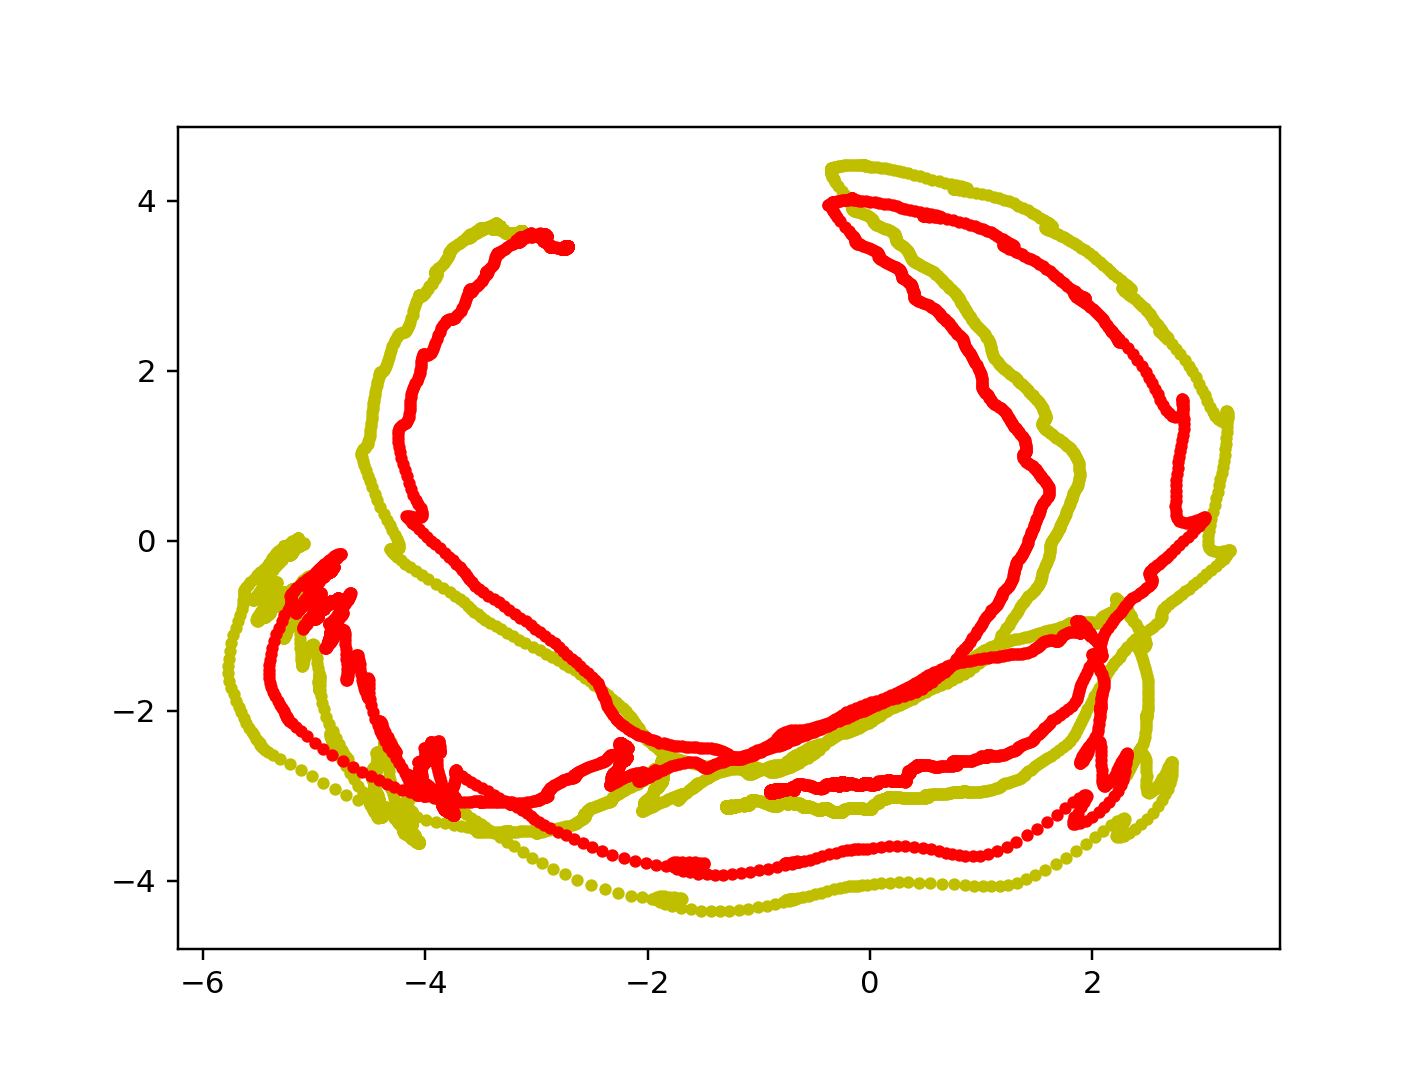

In [143]:
plt.figure()
plt.plot(raw_pd['yellow_x'],raw_pd['yellow_y'],'y.')
plt.plot(raw_pd['red_x'],raw_pd['red_y'],'r.')
plt.show()

### Create vectors from points

In [144]:
vectors = []
vector_mag = []
slopes = []
midpt = []

# vectors = (raw_mat[:,4]-raw_mat[:,0],raw_mat[:,5]-raw_mat[:,1])  #(dx,dy) yellow-red?
vectors = [raw_pd['yellow_x'].astype(float)-raw_pd['red_x'].astype(float), raw_pd['yellow_y'].astype(float)-raw_pd['red_y'].astype(float)]
smooth_vectors = butter_lowpass_lfilter(vectors,0.15,fs=25) #smooth vectors
vector_mag = np.sqrt(vectors[0]**2 + vectors[1]**2)
slopes = vectors[1]/vectors[0]


#MID POINT FOR HEADWAGGING ANALYSIS ONLY
for i in range(len(vectors[0])):
    #midpt.append(([red_mat[i,0]+vectors[0][i]/2,red_mat[i,1]+vectors[1][i]/2]))
    midpt +=[[raw_mat[i,0]+vectors[0][i]/2,raw_mat[i,1]+vectors[1][i]/2]]

# mid_KF = KF2D.fill_in_data(np.array(midpt),raw_pd['frames'].astype(int),120.)
mid_KF = KF2D.fill_in_data(np.array(midpt),np.array(raw_pd['frames'].astype(float)).astype(int),120.)
mid_mag = np.sqrt(mid_KF[0].T[2]**2 + mid_KF[0].T[3]**2)
mid_norm = np.sqrt(mid_KF[0].T[0]**2 + mid_KF[0].T[1]**2)
#mid_KF = np.column_stack((mid_KF[0][:,0],mid_KF[1][:,0],mid_KF[0][:,1],mid_KF[1][:,1],frames))

> /Users/sazamore/Documents/Visuomotor/1-Raw_data/KF2D.py(30)fill_in_data()
(Pdb) c
No missing points detected.


<IPython.core.display.Javascript object>


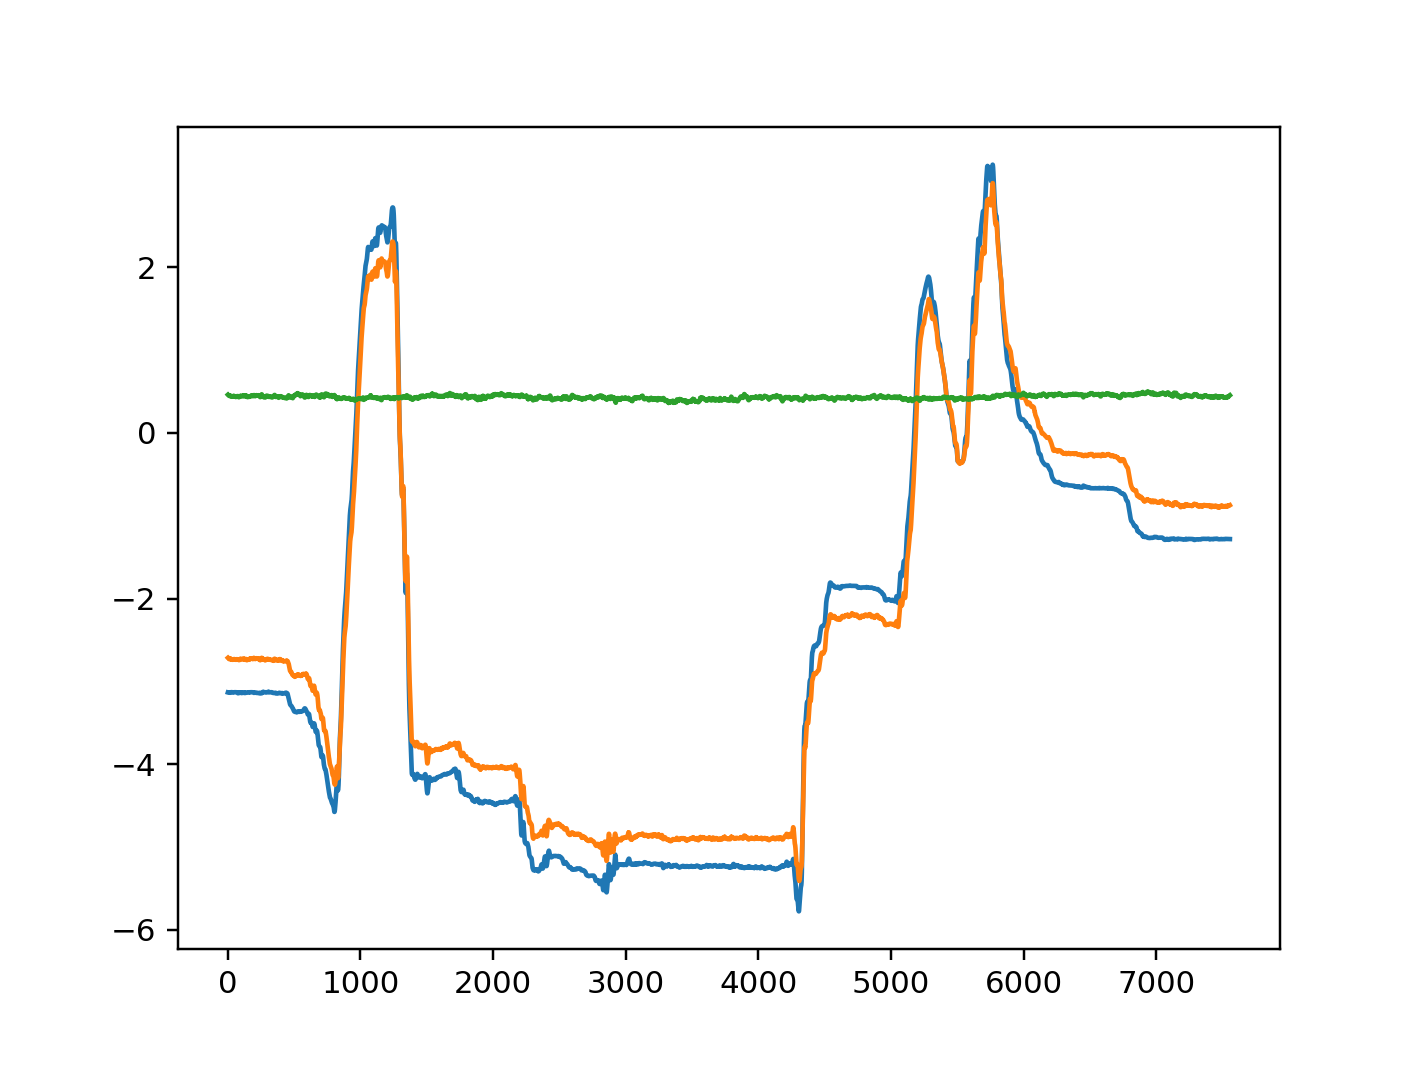

In [145]:
plt.figure()
plt.plot(raw_pd['yellow_x'])
plt.plot(raw_pd['red_x'])

plt.plot(vector_mag)
# plt.plot()

In [197]:
os.chdir('/Users/sazamore/BehaviorVids/GapBridging')
mid_KF = pd.DataFrame.from_csv('119_snake95_position.csv',header=None, index_col = None)
mid_KF = np.column_stack([mid_KF[0].astype(float)/10,mid_KF[1].astype(float)/10])
mid_mag = np.sqrt(np.diff(mid_KF.T[0])**2 + np.diff(mid_KF.T[1])**2)
# mid_mag.append([np.nan,np.nan])
mid_norm = np.sqrt(mid_KF.T[0]**2 + mid_KF.T[1]**2)


<IPython.core.display.Javascript object>


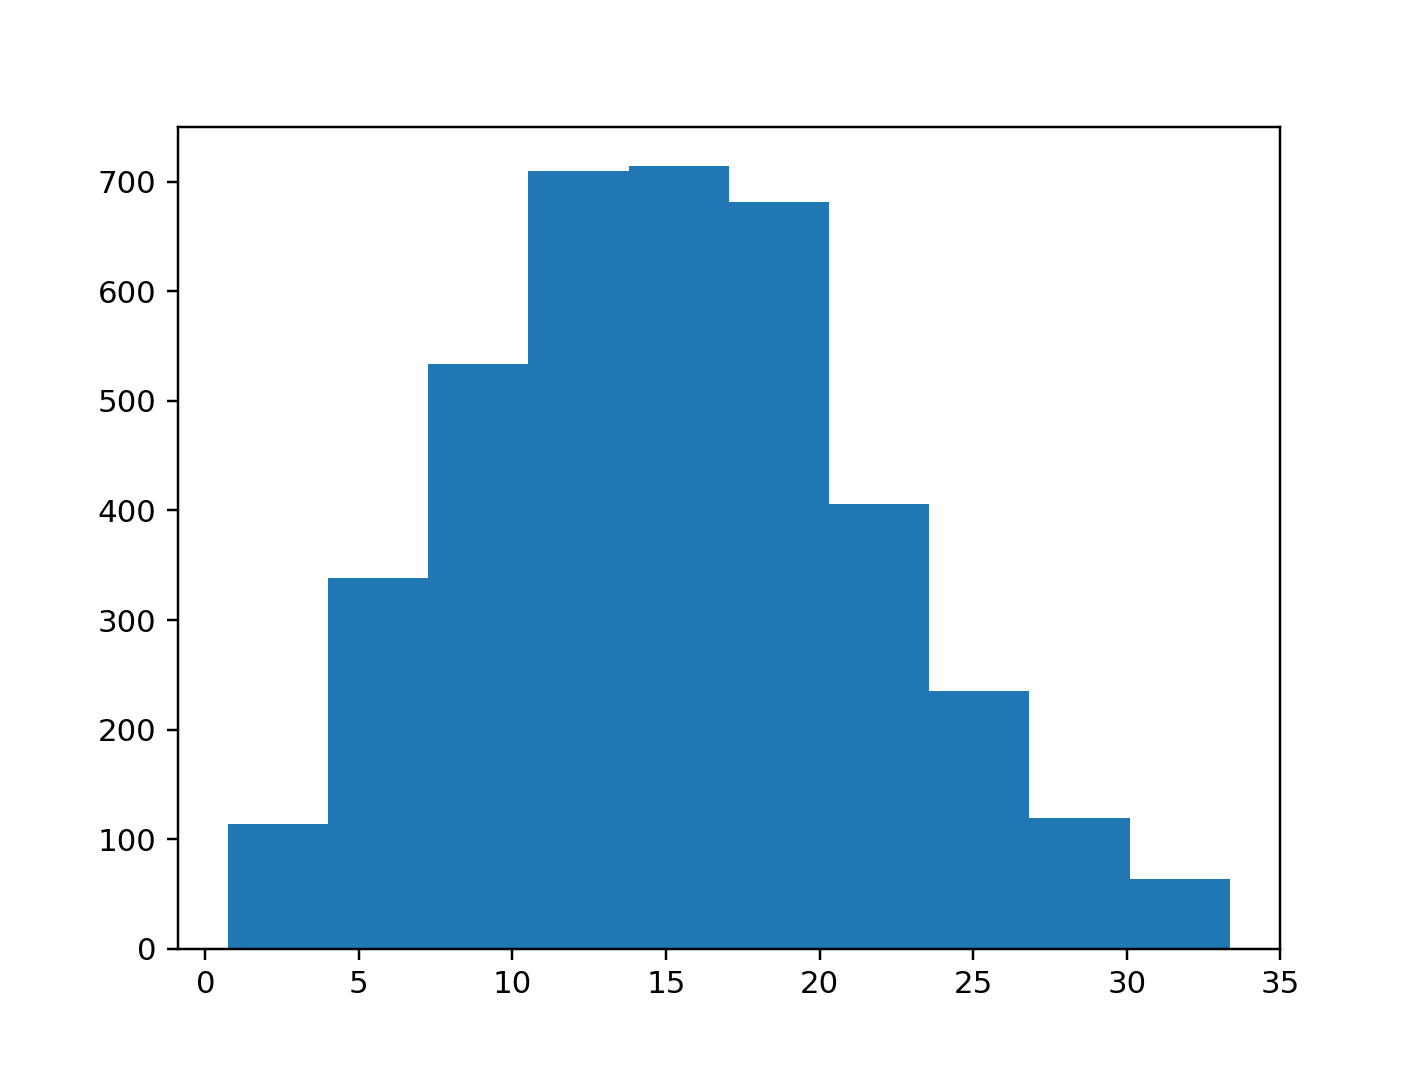

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in arccos


<IPython.core.display.Javascript object>


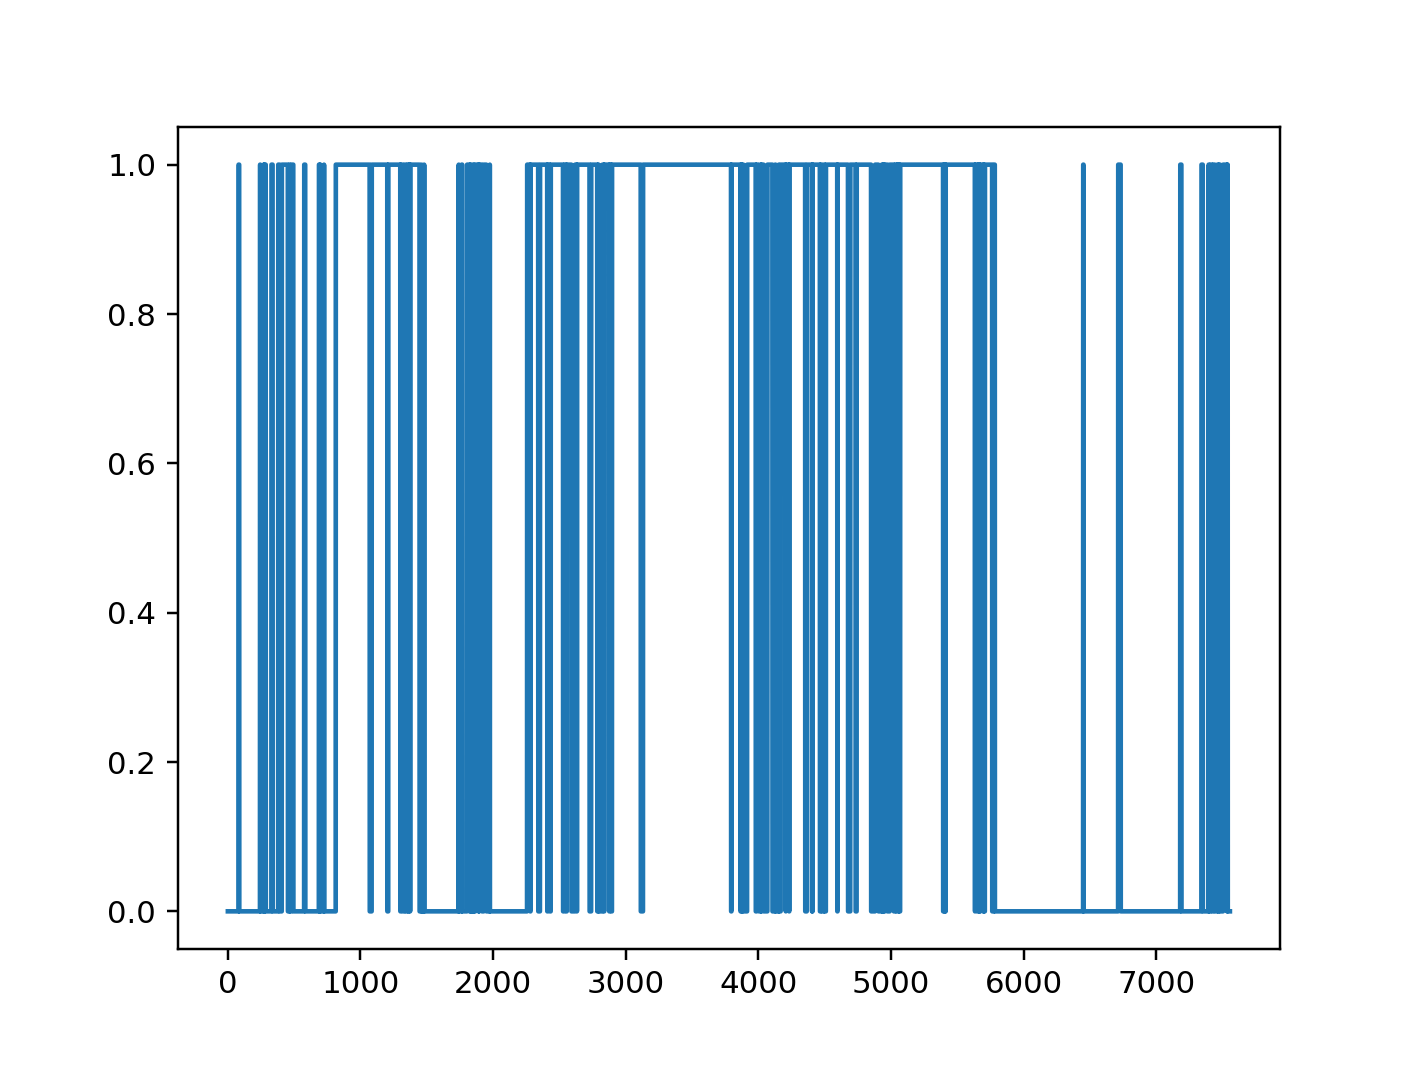

In [146]:
#np.mean(vector_mag)-np.std(vector_mag)
plt.figure()
#plt.hist(vector_mag)
vertHeadAngle = 180/np.pi*np.arccos(vector_mag/np.mean(vector_mag))
plt.hist(vertHeadAngle[~np.isnan(vertHeadAngle)])

valid = vertHeadAngle<=65  #boolean for acceptable head angles (less than 55deg)
plt.figure()
plt.plot(valid)
#plt.plot(0, np.mean(vector_mag[:100]),'ro')


#Tentative cutoff = 55 deg

# Head angle and angular velocity

In [147]:
cmap = plt.cm.Blues
cNorm  = colors.Normalize(vmin=0, vmax=len(vectors[0]))#np.min(DATA[:,4]), vmax=np.max(DATA[:,4]))
#cNorm  = colors.Normalize(vmin=np.min(u_theta), vmax=np.max(u_theta))
scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=cmap)

In [148]:
fs = 25
# frames = raw_mat[:,8] #if errors, try [:,0]
frames = np.array(raw_pd['frames'].astype(float)).astype(int)
# frames = frames.values
T = frames/fs

#get angle from horizontal, in degrees
global theta
#smooth_vectors = butter_lowpass_lfilter(vectors[:2],0.15,fs=25) #vectors already smoothed.
#theta = np.unwrap(np.arctan2(smooth_vectors[1],smooth_vectors[0])) #for my tracker data
theta = np.unwrap(np.arctan2(vectors[1],vectors[0]))
theta_deg = theta*180/(2*np.pi)

#smooth angular velocity
w = np.diff(theta_deg)*fs

#lowpass filter to smooth (2/3: not necessary to smooth)
w_smooth = butter_lowpass_lfilter(w,1.5,fs=25)  #my tracker = 0.5, physlet tracker = 1.5
theta_smooth = butter_lowpass_lfilter(theta_deg,1,fs=25)

<IPython.core.display.Javascript object>


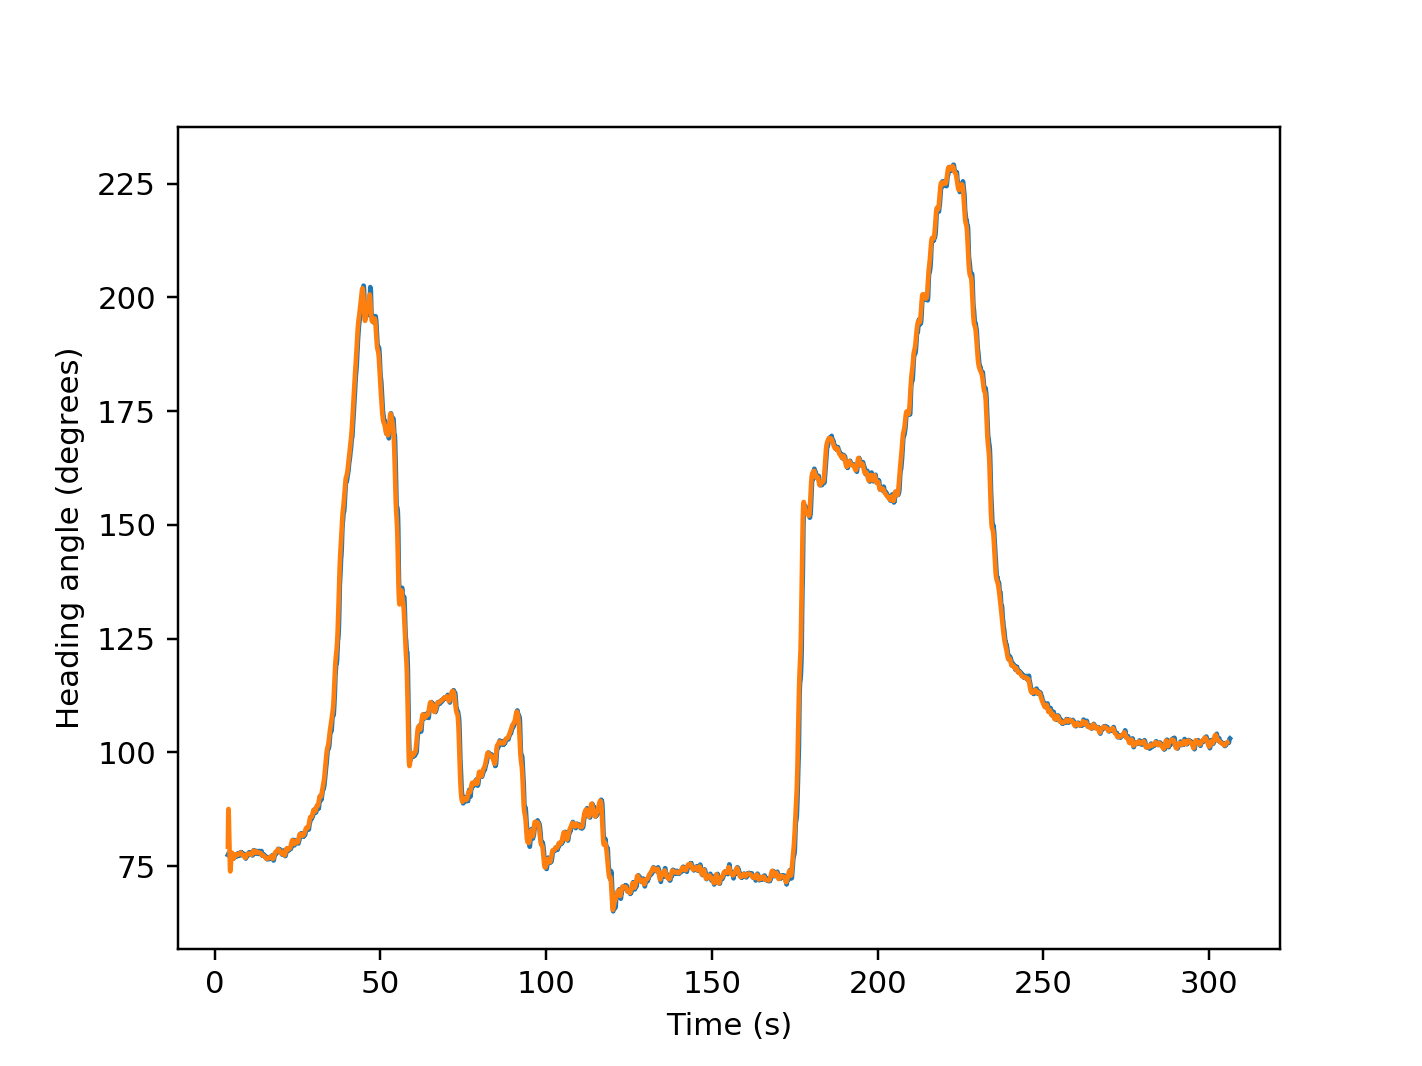

In [149]:
plt.figure()
# for i in range(0,len(theta),4):
#     colorVal = scalarMap.to_rgba(i)
#     plt.plot(T[i],theta_deg[i],'.',color=colorVal)#plt.plot(T[1:],w_smooth,'k')
#for i in range(0,len(w),4):
#    colorVal = scalarMap.to_rgba(i)
#    plt.plot(T[i],w_smooth[i],'.',color=colorVal)
#plt.xlim((20,40))

plt.plot(T,theta_deg)
plt.plot(T[:-20],theta_smooth[20:])
# plt.arrow( 30.5, -30, 0, -1, fc="k", ec="k",head_width=0.3, head_length=0.3 )
# plt.arrow( 32.5, -29.5, 0, -1, fc="k", ec="k",head_width=0.3, head_length=0.3 )
# plt.arrow( 34, -29, 0, -1, fc="k", ec="k",head_width=0.3, head_length=0.3 )

plt.ylabel('Heading angle (degrees)')
plt.xlabel('Time (s)')
plt.show()

<IPython.core.display.Javascript object>


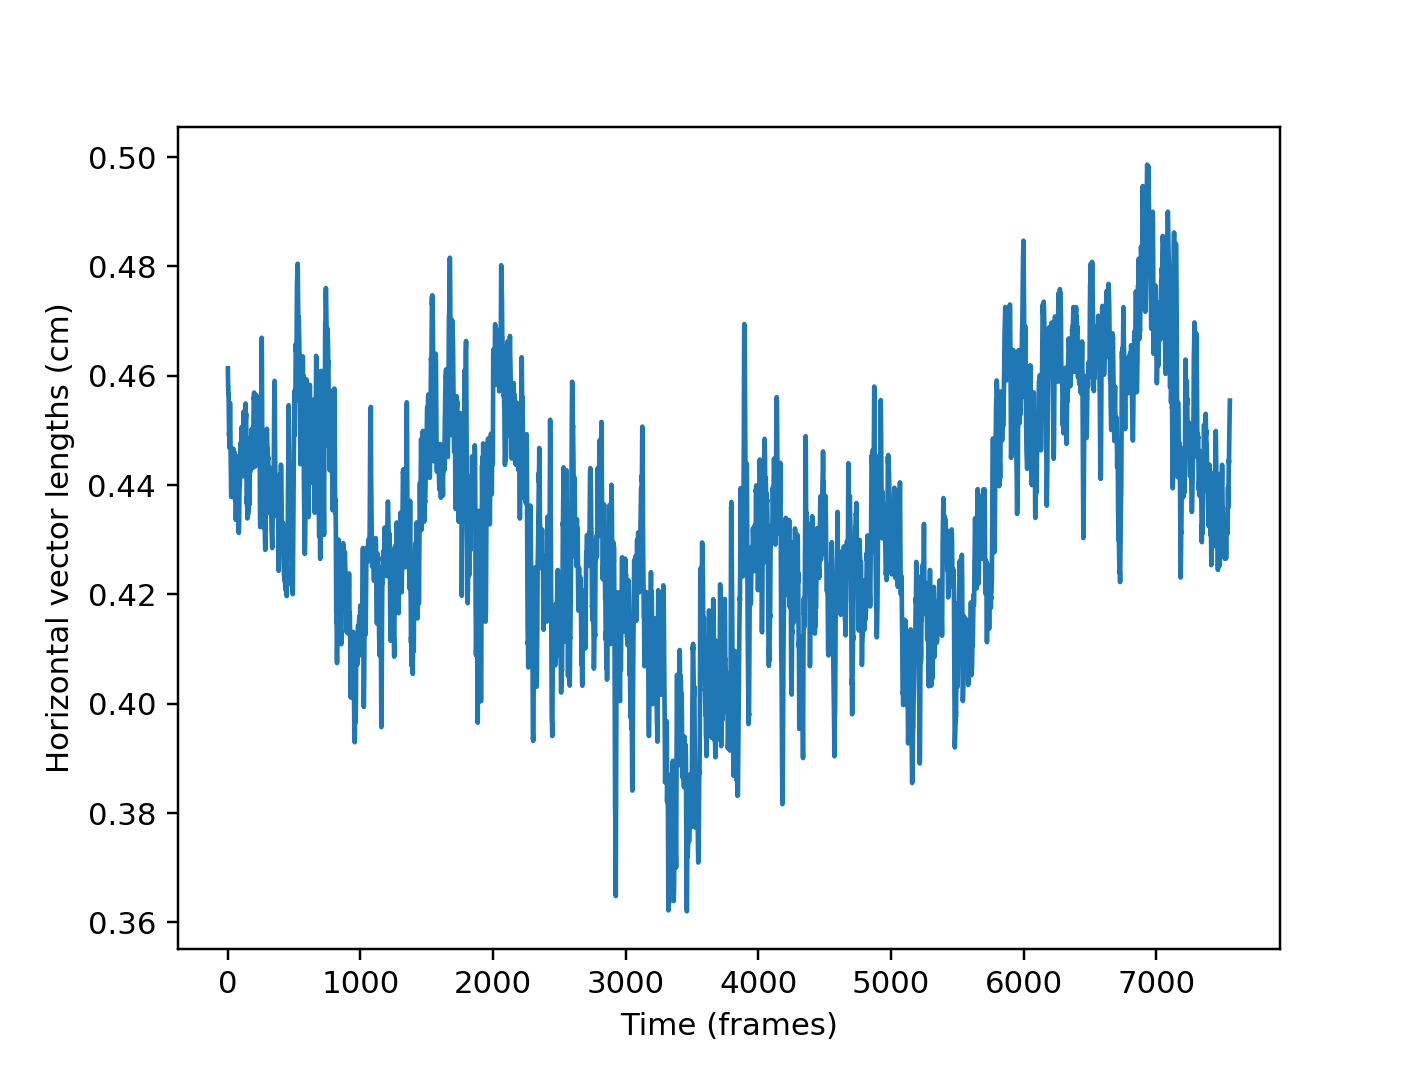

In [151]:
#Smoothed data has an offset equal to the sampling frequency.

plt.figure()
plt.plot(vector_mag)
# plt.plot(w_smooth[10:])
plt.xlabel('Time (frames)')
plt.ylabel('Horizontal vector lengths (cm)')
# plt.title('Smoothed physlet data')
plt.show()

<IPython.core.display.Javascript object>


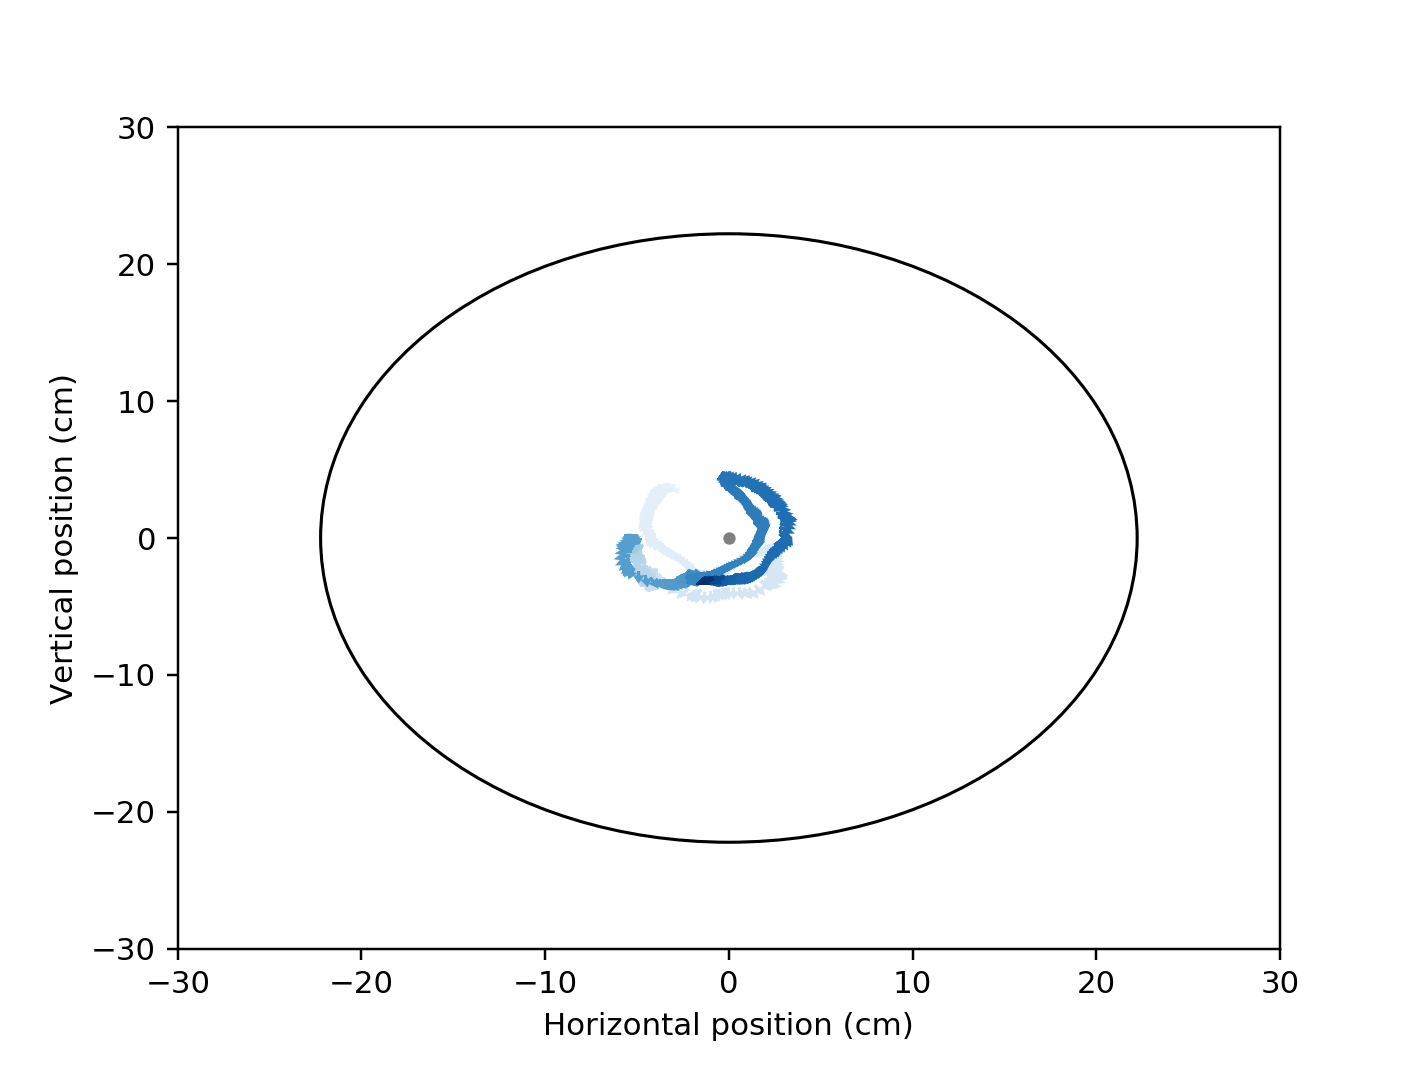

In [152]:
#plot vectors
a = [i[0] for i in sorted(enumerate(theta_deg), key=lambda x:x[1])]

plt.figure()
ax = plt.axes()

for i in range(0,len(vectors[0]),4):
#     if hw_bool[i]:
#         colorVal='r'
#     else:
#     if valid[i]:
    colorVal = scalarMap.to_rgba(i)#a[i]
#     ax.arrow(raw_mat[i,0],raw_mat[i,1],vectors[0][i],vectors[1][i], color=colorVal,head_length=0.3, head_width=0.3)
    ax.arrow(raw_pd['red_x'].astype(float)[i],raw_pd['red_y'].astype(float)[i],vectors[0][i],vectors[1][i], color=colorVal,head_length=0.3, head_width=0.3)

circ1 = plt.Circle((0,0),44.45/2,color='k',fill=False)
ax.add_artist(circ1)
plt.plot(0,0,'.',color='gray')
# plt.axis('equal')
plt.xlim((-30,30))
plt.ylim((-30,30))
plt.xlabel('Horizontal position (cm)')
plt.ylabel('Vertical position (cm)')
# plt.plot(mid_KF[0][:,0],mid_KF[0][:,1])
plt.show()

# Nystagmus detection

In [153]:
def calc_gains(x,y,start,end, angvel, gains, nyst_time):
    linfit = scipy.stats.linregress(x[start:end],y[start:end]) 
    slopes.append(linfit.slope)
    if np.abs(linfit.slope/rot_speed) < 5:
        #nyst_bool[start:end] = True
        angvel.append(np.mean(w[start:end]))
        gains.append(linfit.slope/rot_speed)
        nyst_time.append(T[int(start)])
    return angvel, gains, nyst_time 

In [155]:
#Import experimental log file to get rotation direction
exp_log = pd.read_csv('/Users/sazamore/Documents/Visuomotor/experiment_log.csv')
rot_dir = exp_log[(exp_log['Date']==Date) & (exp_log['Speed']==rot_speed/6)]['1st rot'].values[0][:2]
#This line ^ took me 90 minutes to figure out this line

In [ ]:
## Determine nystagmus with Nystagmus script

# CPD (slow)

In [111]:
grating = eval(exp_log[(exp_log['Date']==Date) & (exp_log['ID']==ID) & (exp_log['Speed']==rot_speed/6)]['Grating'].values[0])
print('Grating size is {} in.'.format(grating))
grating = [grating *2.54]    #get grating distance in cm
global grating
per = 2*grating    #calculate period
diam = 44.45  #diameter in cm

x,y = cpd.make_circ(diam/2)
circle = cpd.Polygon(zip(x,y))
dt = np.linspace(0.01,44.45,800)

#cpd,view_dist = cpd.calc_view_dist(yellow_mat[:,:2],vector_mag)
#previously rawmat[:,4:6]. this does not ascertain that yellow (x,y) are actually being grabbed.
spDens,view_dist = cpd.calc_view_dist(raw_mat[:,4:6],vector_mag,circle,theta,grating,dt) #use yellow marker (x,y) as positions (first entry)

spDens = np.array(spDens)

Grating size is 0.05 in.


In [27]:
#HW and NYST now done externally.

4555

# Save data (pickle)

In [113]:
#placeholders for HW and nyst
nyst_bool = np.zeros((len(frames)))
hw_bool = nyst_bool
np.shape(frames),len(raw_mat),len(spDens),np.shape(raw_pd[['red_x','red_y']].as_matrix())

((4349,), 4349, 4349, (4349, 2))

In [114]:
processed_data = np.column_stack((frames,raw_pd[['red_x','red_y','red x vel','red y vel']].as_matrix(),\
                                  raw_pd[['yellow_x','yellow_y','yellow x vel','yellow y vel']].as_matrix(),\
                                  vectors[0],vectors[1],\
                                  vector_mag,theta,view_dist,spDens,nyst_bool,hw_bool))

processed_pd = pd.DataFrame(processed_data,
                      columns = ['frames','red_x','red_y','red x vel','red y vel','yellow_x',\
                                 'yellow_y','yellow x vel','yellow y vel','vector_dx','vector_dy',\
                                'vector_mag','theta','view dist','cpd','nyst_bool','hw_bool'])
savename = filename[:len(filename)-5]+'processed.csv'
print('Savename will be {}'.format(savename))
#nameOK = input('Continue with savename? (Y/n) ')

#if np.strmatch('n'):
#    savename = input('Enter savename, complete with extentsion: ')

os.chdir('/Users/sazamore/Documents/Visuomotor/2-Processed_data/')
processed_pd.to_csv(savename)
print('Data saved to {}'.format(savename))
#processed_pd.to_pickle('94_0.5rpm1_processed.p')

Savename will be 94_161130_10rpprocessed.csv
Data saved to 94_161130_10rpprocessed.csv


# Headwag detection - to be deleted

In [ ]:
#Use HW function found in separate script. 

Nx is 64
Frequency threshold is 1
(0.00092752116212861419, 0.0114634302676464)


<IPython.core.display.Javascript object>


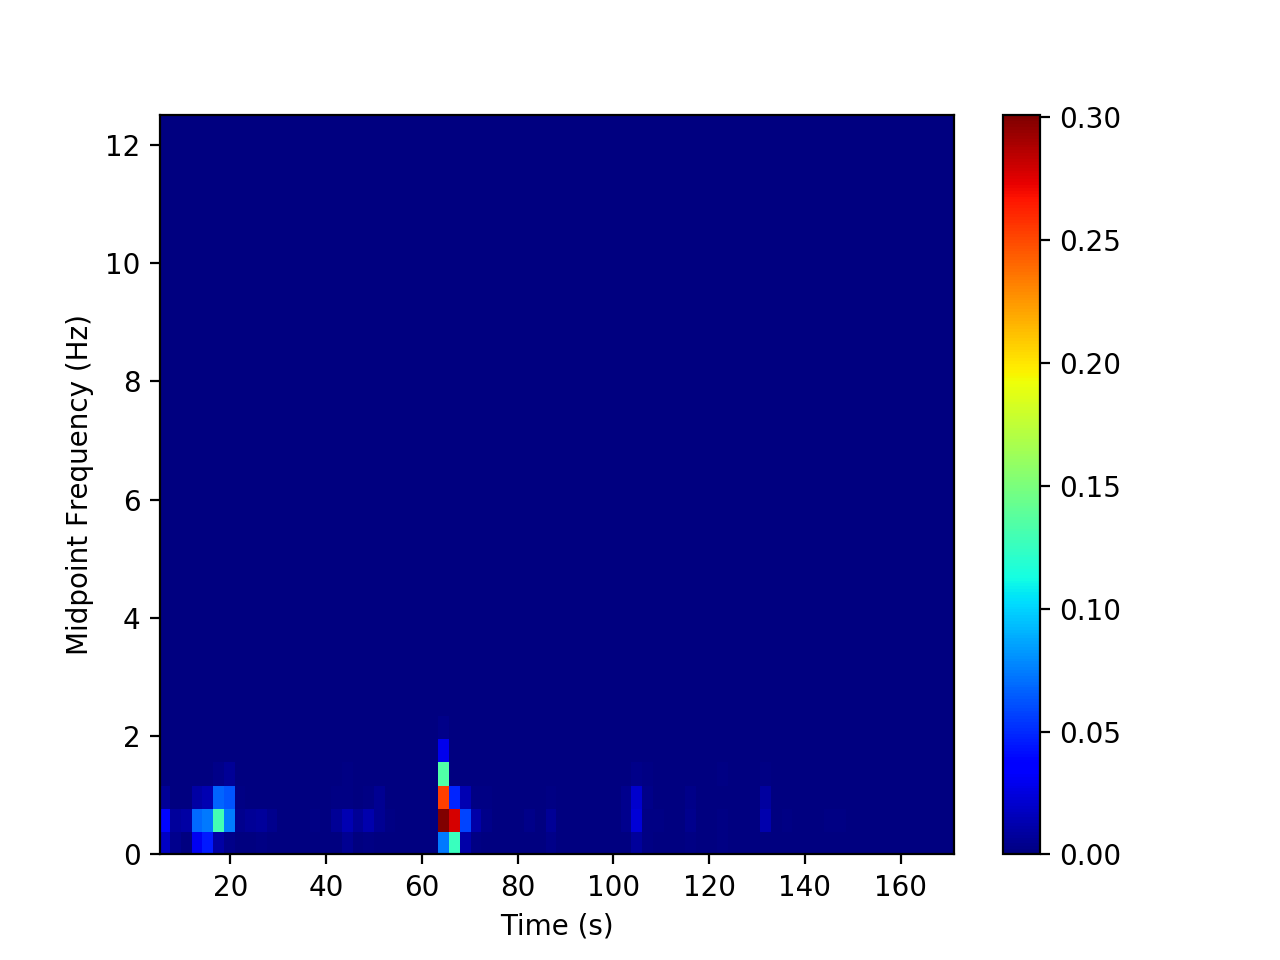

0
1
2
3
4
5
6
7
8
9
10
14
16
17
18
19
20
21
26
27
28
29
30
34
36
43
44
45
46
49
50
52
56
58
62
63


In [112]:
N = len(mid_mag) #number samples
# fs = 25

HPF_mid = butter_highpass_lfilter(mid_norm,.2,25)#.1
BPF_mid = butter_lowpass_lfilter(HPF_mid,2.5,25)#.9

#make window
x = len(BPF_mid[100:])
Nx = int(pow(2, np.floor(np.log(x)-1/np.log(2)))); #find window size (nearest base 2 value less than length of data), based on length of values
win = scipy.signal.get_window('hann',Nx=Nx)
print('Nx is {}'.format(Nx))

#start 100 timesteps in, to get rid of onset ringing
f_x, t_x, S_x = scipy.signal.spectrogram(HPF_mid[100:],fs=fs,window=win,nfft=Nx,nperseg=Nx)#red_mat[:,2],fs) #x velocity

thresh_f = next(x[0] for x in enumerate(f_x) if x[1] > 0) #frequency threshold
print("Frequency threshold is {}".format(thresh_f))
s_dt = np.diff(t_x)[0]   #timestep of spectrogram
dt = np.diff(t_x)[0]*25

print(np.mean(S_x),np.std(S_x))

#plot spectrogram
plt.figure()
plt.pcolormesh(t_x+T[0], f_x, S_x, cmap='jet')
plt.colorbar()
plt.ylabel('Midpoint Frequency (Hz)') #previously "xdot freq" is this velocity? pretty sure this is position
plt.xlabel('Time (s)')
plt.ylim((0,fs/2))
plt.show()

#frame number where headwagging occurs
head_wag = []
head_wag_idx = []
hw_freq = []

#find where frequency is larger than some threshold. Currently 0.02, not sure why.
for i in range(S_x.shape[1]-1):
    if max(S_x[thresh_f:,i])>=0.001:
        print(i)
        head_wag.append(np.round(t_x.T[i] + T[0],2))# + s_dt*1.5)))
        hw_freq.append(f_x[list(np.where(S_x==max(S_x[thresh_f:,i]))[0])]) #finds dominant power frequency
        #hw_freq.append(f_x[thresh_f:,i])

#get indices where head wagging is detected
for i in range(len(head_wag)):
    if i==head_wag[i-1]+s_dt:
        continue
    else:
        head_wag_idx.append(list(np.where(np.round(T,2)==head_wag[i])[0])[0])  #+T[0] deals with time offset between real time and spectrogram time
    
hw_events = []
hw_cpd = []
hw_vd = []
hw_loc = []
hw_bool = np.zeros(np.size(HPF_mid), dtype=bool)

#TODO: get rid of hw_events. ultimately only have hw_bool, 
#TODO: make separate cell for hw_cpd, hw_vd
#for i in range(len(head_wag_idx)-1):
for row in head_wag_idx:
    #row = row[0]
    if row+Nx < len(raw_mat[:,0]):
        hw_loc.extend(range(row,row+Nx))
        hw_events.extend(raw_mat[row:row+Nx,0])
        hw_bool[row:row+Nx]=True
    else:
        hw_loc.extend(range(row,row+Nx))
        hw_events.extend(raw_mat[row:,0])
        hw_bool[row:]=True
    hw_cpd.append(spDens[row:row+Nx])#append  window range of spatial density values
    hw_vd.append(view_dist[row:row+Nx])

In [43]:
fs = 150
T = np.zeros((len(mid_KF[0]),1))
for i in range(len(mid_KF)):
    T[i] = i/fs
T

array([[ 0.        ],
       [ 0.00666667],
       [ 0.01333333],
       ..., 
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [143]:
# T = range(len(mid_KF)-1)
plt.figure()
plt.subplot(211)
plt.plot(T[1:],mid_mag)
plt.plot(T,mid_norm)

plt.ylabel('Midpt velocity mag (cm/c)')

# plt.subplot(212)
# plt.plot(T[1:],HPF_mid,label='HPF (0.3+Hz)')
# plt.plot(T[1:-7],BPF_mid[7:],label='BPF (0.3-2.5Hz)')
# plt.ylabel('Midpt vel magnitude (cm/s)')
# plt.legend()
# plt.xlabel('Time (s)')

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (2750,) and (2751,)

In [55]:
#Head wag statistics - hw frequency, duration, amplitude, spatial density
# hw_spDens = np.mean(spDens[hw_bool])
# hw_std_spDens = np.std(spDens[hw_bool])
# hw_mfreq = np.mean(hw_freq)
# hw_sfreq = np.std(hw_freq)

analytic_signal = hilbert(mid_mag)
amplitude = np.mean(np.abs(analytic_signal[hw_bool]))
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
hw_mfreq = np.mean(np.diff(instantaneous_phase[hw_bool])/(2.0*np.pi) * fs)
hw_sfreq = np.std(np.diff(instantaneous_phase[hw_bool])/(2.0*np.pi) * fs)

# amplitude = np.mean(np.abs(mid_mag))
amp_s = np.std(np.abs(analytic_signal[hw_bool]))#np.std(np.abs(mid_mag))

# hw_spDens, 
hw_mfreq, amplitude, amp_s, 

(-0.0042233217691408764, 4.4860009321424101, 1.3684788832844443)

<IPython.core.display.Javascript object>


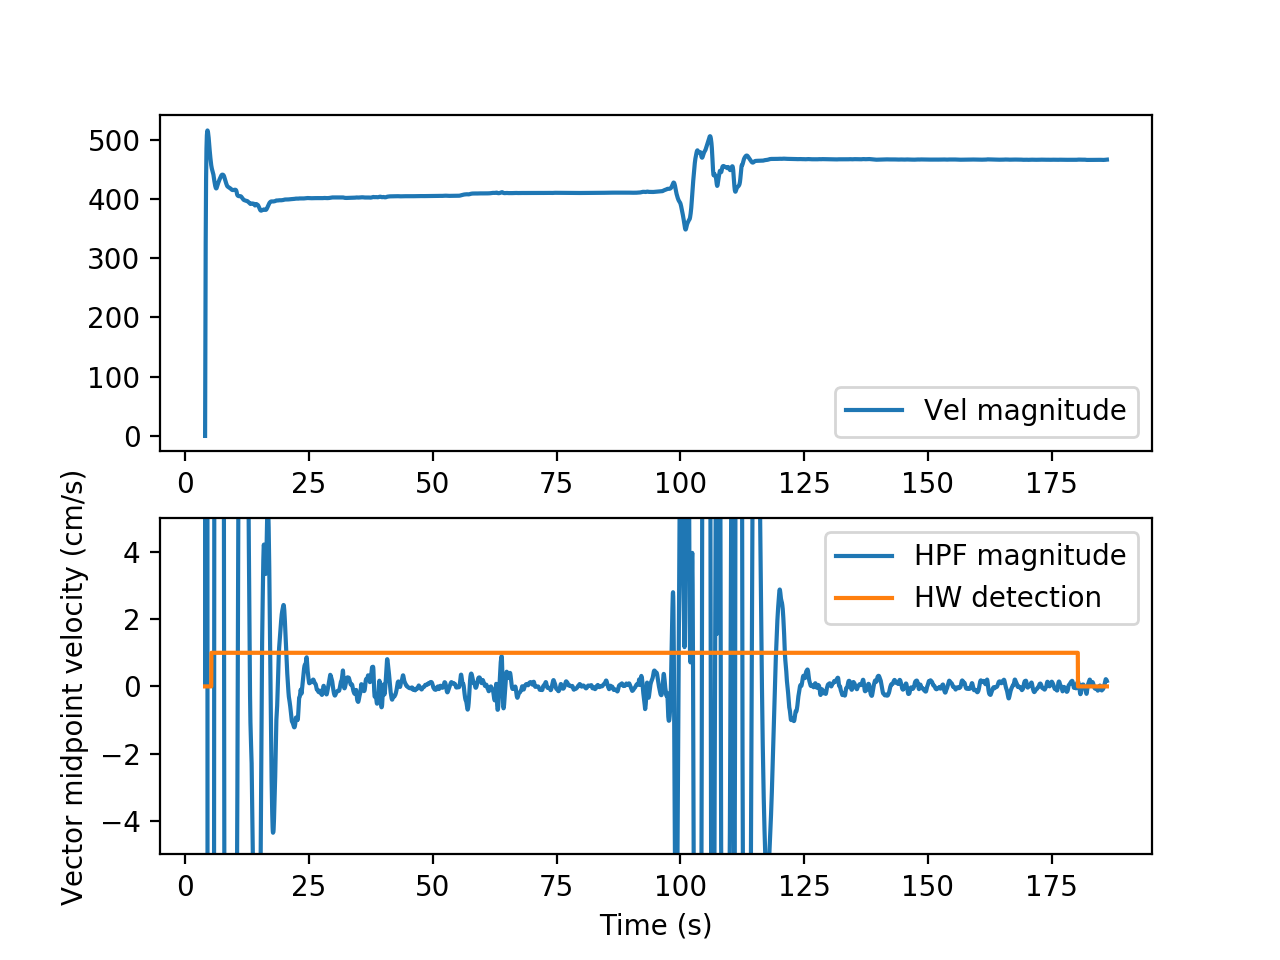

In [29]:
plt.figure()
plt.subplot(211)
plt.plot(T,mid_norm, label = 'Vel magnitude')
plt.legend()
# #plt.plot(HPF_mid)
# plt.plot(BPF_mid)
# plt.plot(hw_loc, HPF_mid[hw_loc],'.')
# plt.ylabel('Vector midpoint velocity (cm/s)')
# #plt.plot(hw_bool)
# plt.ylim((-2,12))
plt.subplot(212)
plt.plot(T,HPF_mid, label ='HPF magnitude')
#plt.plot(hw_loc, spDens[hw_loc],'.')
plt.plot(T,hw_bool, label = "HW detection")
# plt.plot(T,np.abs(analytic_signal), label = "Envelope")
plt.ylabel('Vector midpoint velocity (cm/s)')
plt.ylim((-5,5))
plt.legend()
plt.xlabel('Time (s)')


## amassing hw data. to be deleted

In [51]:
hw_cpd=[]
for loc in hw_loc:
    hw_cpd.append(spDens[loc])

In [52]:
hwdata = {'spDens':[],'spDens_sd':[],'freq':[],'freq_sd':[],'amp':[],'amp_sd':[],'ID':[],'spd':[],'grat':[],'date':[]}

In [151]:
hwdatapd = pd.DataFrame(hwdata)
hwdatapd.to_csv('hwdata-94.csv')

In [46]:
os.chdir('/Users/sazamore/Documents/Visuomotor/Raw_data/')
hwdatapd = pd.DataFrame.from_csv('hwdata-94.csv')
hwdatapd = hwdatapd.drop(3)
hwdata = hwdatapd.to_dict('list')
hwdata

{'ID': [94, 94, 94, 94, 94, 94],
 'amp': [0.745431484808,
  0.649644913893,
  0.8210413754960001,
  0.562045719784,
  0.535136739243,
  1.5199168664899998],
 'amp_sd': [0.5171686698219999,
  0.41311261147100004,
  0.546876414501,
  0.441829391261,
  0.7565067358249999,
  1.3873535813999998],
 'date': [170329, 170329, 170329, 170329, 170329, 170329],
 'freq': [0.446270867562,
  0.22934830607599999,
  0.242318638743,
  0.30884860866700004,
  0.26212381414,
  0.514476365057],
 'freq_sd': [4.44456878493,
  4.49357855851,
  4.930153210309999,
  9.187816251100001,
  2.88901383711,
  10.9065517208],
 'grat': ['[0.127]', '[0.127]', '[0.127]', '[0.127]', '[0.127]', '[0.127]'],
 'spDens': [3.41206706325,
  3.38877814189,
  3.5581557004800004,
  3.33116419476,
  4.082046622219999,
  4.511844180330001],
 'spDens_sd': [0.621718824561,
  0.602527209071,
  0.599096838798,
  0.618178039508,
  1.3865673424399998,
  2.19494239975],
 'spd': [24.0, 30.0, 48.0, 12.0, 6.0, 3.0]}

In [114]:

hwdata['spDens'].append(hw_spDens)
hwdata['spDens_sd'].append(hw_std_spDens)
hwdata['freq'].append(hw_mfreq)
hwdata['freq_sd'].append(hw_sfreq)
hwdata['amp'].append(amplitude)
hwdata['amp_sd'].append(amp_s)
hwdata['ID'].append(ID)
hwdata['spd'].append(rot_speed)
hwdata['grat'].append(grating)
hwdata['date'].append(Date)


In [73]:
Hz = []
for i in range(8):
    Hz.append(hwdata['spDens'][i]*hwdata['spd'][i])
Hz
# hwdata['spDens'][0],hwdata['spd']

[81.889609518,
 101.6633442567,
 170.79147362304002,
 39.97397033712,
 24.492279733319997,
 13.535532540990001,
 43.147433626847295,
 36.32762682692308]

In [149]:
gap_dist = 27
width = 1.5*2.54
cpd_gap,(round(1./(np.arctan(width/gap_dist))/57.295779513,5))

(0.2615, 0.1245)

<IPython.core.display.Javascript object>


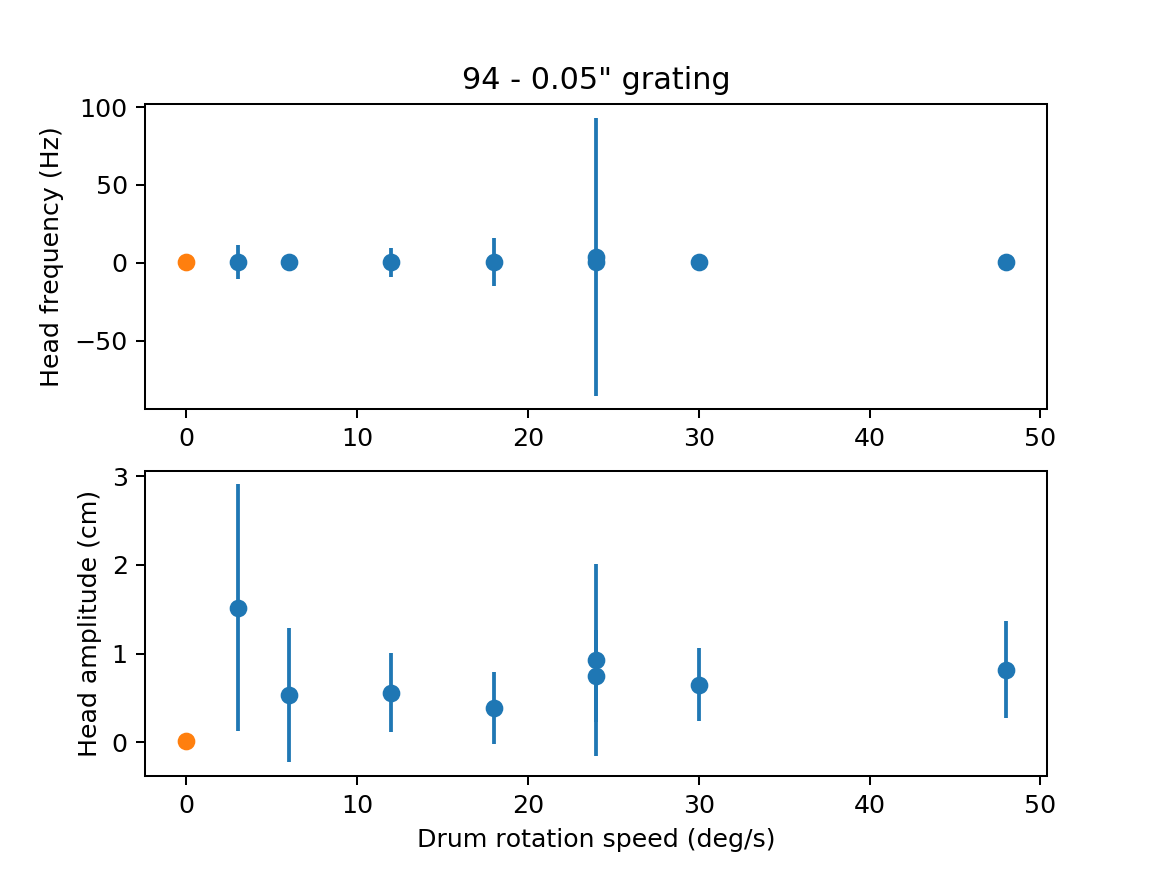

In [256]:
#plot gap bridging 
plt.figure()
plt.subplot(211)
plt.title('94 - 0.05" grating')
plt.ylabel('Head frequency (Hz)')
plt.errorbar(hwdata['spd'][:8], hwdata['freq'][:8],yerr=hwdata['freq_sd'][:8],fmt='o',label = 'OKR')
plt.errorbar(0, hw_mfreq,yerr=hw_sfreq,fmt='o',label = 'Gap bridging')

plt.subplot(212)
plt.errorbar(hwdata['spd'][:8], hwdata['amp'][:8],yerr=hwdata['amp_sd'][:8],fmt='o',label = 'OKR')
plt.errorbar(0, amplitude, yerr=amp_s, fmt='o',label = 'Gap bridging')

plt.ylabel('Head amplitude (cm)')

plt.xlabel('Drum rotation speed (deg/s)')

In [255]:
plt.figure(5)
plt.subplot(211)
plt.errorbar(0, hw_mfreq,yerr=hw_sfreq,fmt='o',label = 'Gap bridging')
plt.subplot(212)
plt.errorbar(0, amplitude, yerr=amp_s, fmt='o',label = 'Gap bridging')
plt.show()

In [ ]:
plt.figure()
plt.subplot(221)
plt.title('94 - 0.05" grating')
plt.ylabel('Head frequency (Hz)')
plt.errorbar(hwdata['spd'], hwdata['freq'],yerr=hwdata['freq_sd'],fmt='o',label = 'Frequecy (Hz)')

plt.subplot(222)
plt.errorbar(hwdata['spd'], hwdata['amp'],yerr=hwdata['amp_sd'],fmt='o',label = 'Amplitude (cm)')
plt.ylabel('Head amplitude (cm)')

plt.subplot(223)
plt.errorbar(hwdata['spd'], hwdata['spDens'],yerr=hwdata['spDens_sd'],fmt='o',label = 'Spatial Density(cpd)')
plt.ylabel('Spatial density (cpd)')

plt.subplot(224)
plt.errorbar(hwdata['spd'], Hz,fmt='o',label = 'Flicker rate (Hz)')
plt.ylabel('Temporal density (Hz)')
# plt.legend()
plt.xlabel('Drum rotation speed (deg/s)')

In [93]:
processed_pd

,frames,red_x,red_y,red x vel,red y vel,yellow_x,yellow_y,yellow x vel,yellow y vel,vector_dx,vector_dy,vector_mag,theta,view dist,cpd,nyst_bool,hw_bool
0,100.0,3.682560,-1.783649,0.281347,0.321159,3.717423,-2.256798,0.384199,0.391133,0.034863,-0.473149,0.474432,-1.497247,23.839800,3.27628,0.0,0.0
1,101.0,3.689199,-1.790651,0.281352,0.321188,3.724036,-2.261981,0.384202,0.391154,0.034838,-0.471330,0.472616,-1.497017,23.846861,3.27725,0.0,0.0
2,102.0,3.693682,-1.798830,0.281358,0.321211,3.728053,-2.265622,0.384206,0.391165,0.034370,-0.466792,0.468056,-1.497298,23.848308,3.27744,0.0,0.0
3,103.0,3.696254,-1.806765,0.281365,0.321227,3.730390,-2.268127,0.384210,0.391169,0.034135,-0.461362,0.462623,-1.496942,23.852668,3.27804,0.0,0.0
4,104.0,3.697512,-1.812956,0.281372,0.321239,3.731854,-2.269705,0.384214,0.391171,0.034342,-0.456749,0.458038,-1.495749,23.861982,3.27932,0.0,0.0
5,105.0,3.697865,-1.817248,0.281377,0.321248,3.732895,-2.270052,0.384217,0.391172,0.035030,-0.452804,0.454157,-1.493588,23.877500,3.28146,0.0,0.0
6,106.0,3.697883,-1.819136,0.281380,0.321255,3.733670,-2.269710,0.384220,0.391173,0.035787,-0.450574,0.451993,-1.491538,23.892039,3.28345,0.0,0.0
7,107.0,3.698187,-1.818400,0.281382,0.321264,3.734445,-2.269025,0.384222,0.391174,0.036258,-0.450626,0.452082,-1.490508,23.899667,3.28450,0.0,0.0
8,108.0,3.699186,-1.815886,0.281382,0.321275,3.735327,-2.268238,0.384224,0.391175,0.036142,-0.452352,0.453793,-1.491068,23.896617,3.28408,0.0,0.0
9,109.0,3.701044,-1.812448,0.281381,0.321289,3.736278,-2.267515,0.384226,0.391177,0.035234,-0.455066,0.456428,-1.493525,23.880769,3.28191,0.0,0.0
